# Patching the Cross Validation Performance of Various Feature Sets

The `provean_score` and `ddG` values were used without any threshold. This results in creating undesirable rules for these single feature values.
Here we use either a fixed threshold value or an adaptive threshold value for these single features.


In [1]:
import os

os.chdir("../")

In [2]:
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import BaseEstimator

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import copy

from tqdm.notebook import tqdm

from src.helpers.helpers_predator.common import load_predator

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [3]:
PREDATOR_PATH = "PredatorModels/PredatorModel_2021-10-24/04f37897/predator.pkl"

In [4]:
predator = load_predator(PREDATOR_PATH)

Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomizedSearchCV from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


2021-12-25 14:31:48 | INFO     | src.helpers.helpers_predator.common | Predator object PredatorModels/PredatorModel_2021-10-24/04f37897/predator.pkl is loaded successfully.


In [5]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [6]:
Xs_ddG = copy.deepcopy(predator.data_materials["Xs_ddG"])
Xs_provean = copy.deepcopy(predator.data_materials["Xs_provean"])
ys = copy.deepcopy(predator.data_materials["ys"])

In [7]:
def get_decision_tree_threshold_val(clf_param):
    text_representation = tree.export_text(clf_param)
    thr_val = float(text_representation.split("\n")[0].split()[-1])
    return thr_val

In [8]:
# class BaselineThresholdClassifier(BaseEstimator):
#     def __init__(self, threshold, classify_func):
#         self.threshold = threshold
#         self.classify_func = classify_func
#
#     def fit(self, X, y=None):
#         pass
#
#     def predict(self, X):
#         return np.array([self.classify_func(val) for val in X["Final_ddG"]])


# class BaselineDeltaDeltaGAdaptiveClassifier(DecisionTreeClassifier):
#     """
#     Uses the threshold value that separates the data instances best.
#     """
#
#     MAX_DEPTH = 1
#
#     def __init__(self, max_depth=MAX_DEPTH):
#         self.max_depth = max_depth
#         super().__init__(max_depth=max_depth)


In [9]:
class BaselineProveanClassifier(BaseEstimator):
    """
    Prediction: "Deleterious" if the score is less than or equal to a predefined threshold.
    For our classification:
        if Provean <= thr:
            deleterious (disrupting, class 0)
        else:
            non deleterious (increasing or no effect, class 1)
    """
    PROVEAN_DEFAULT_THRESHOLD = -2.5
    FEATURE_NAME = "Provean_score"

    def __init__(self, feature_name=FEATURE_NAME, threshold=PROVEAN_DEFAULT_THRESHOLD):
        self.feature_name = feature_name
        self.threshold = threshold

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.array([self.apply_threshold(val) for val in X[self.feature_name]])

    def apply_threshold(self, val):
        if val <= self.threshold:
            return 0  # class 0: disrupting

        else:
            return 1  # class 1: increasing + no effect

In [10]:
class BaselineDeltaDeltaGClassifier(BaseEstimator):
    """
    todo: could not find it explicitly, re check
    """
    DELTA_DELTA_G_DEFAULT_THRESHOLD = 0
    FEATURE_NAME = "Final_ddG"

    def __init__(self, feature_name=FEATURE_NAME, threshold=DELTA_DELTA_G_DEFAULT_THRESHOLD):
        self.feature_name = feature_name
        self.threshold = threshold

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.array([self.apply_threshold(val) for val in X[self.feature_name]])

    def apply_threshold(self, val):
        if val < self.threshold:
            return 0  # class 0: disrupting

        else:
            return 1  # class 1: increasing + no effect

In [11]:
from sklearn.tree import DecisionTreeClassifier

class BaselineAdaptiveThresholdClassifier(DecisionTreeClassifier):
    """
    Uses the threshold value that separates the data instances best.
    """

    MAX_DEPTH = 1

    def __init__(self, max_depth=MAX_DEPTH):
        self.max_depth = max_depth
        super().__init__(max_depth=max_depth)

In [133]:
foo = DecisionTreeClassifier()
foo.criterion

'gini'

In [12]:
clf = BaselineAdaptiveThresholdClassifier()
clf.fit(Xs_ddG[0][:132], ys[0][:132])
clf.predict(Xs_ddG[0][132:])

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [13]:
balanced_accuracy_score(ys[0][132:], clf.predict(Xs_ddG[0][132:]))

0.699134199134199

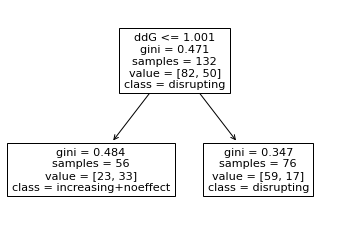

In [14]:
fig = plt.figure()
_ = tree.plot_tree(clf, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"])

In [15]:
get_decision_tree_threshold_val(clf)

1.0

In [16]:
X_ddG_sample = Xs_ddG[0]
X_provean_sample = Xs_provean[0]
y_sample = ys[0]

In [17]:
clf = BaselineProveanClassifier()
clf.fit(None, None)
pred = clf.predict(X_provean_sample)
pd.DataFrame(pred).value_counts()

0    144
1     20
dtype: int64

In [18]:
clf = BaselineDeltaDeltaGClassifier()
clf.fit(None, None)
pred = clf.predict(X_ddG_sample)
pd.DataFrame(pred).value_counts()

1    149
0     15
dtype: int64

In [19]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X_ddG_sample, y_sample)
print(clf.tree_.max_depth)

1


In [20]:
clf.classes_

array([0, 1], dtype=int64)

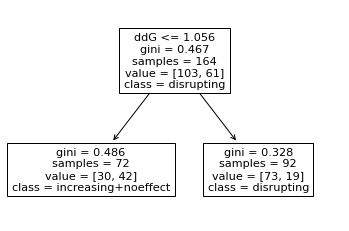

In [21]:
plt.figure()
_ = tree.plot_tree(clf, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"])

In [22]:
get_decision_tree_threshold_val(clf)

1.06

5


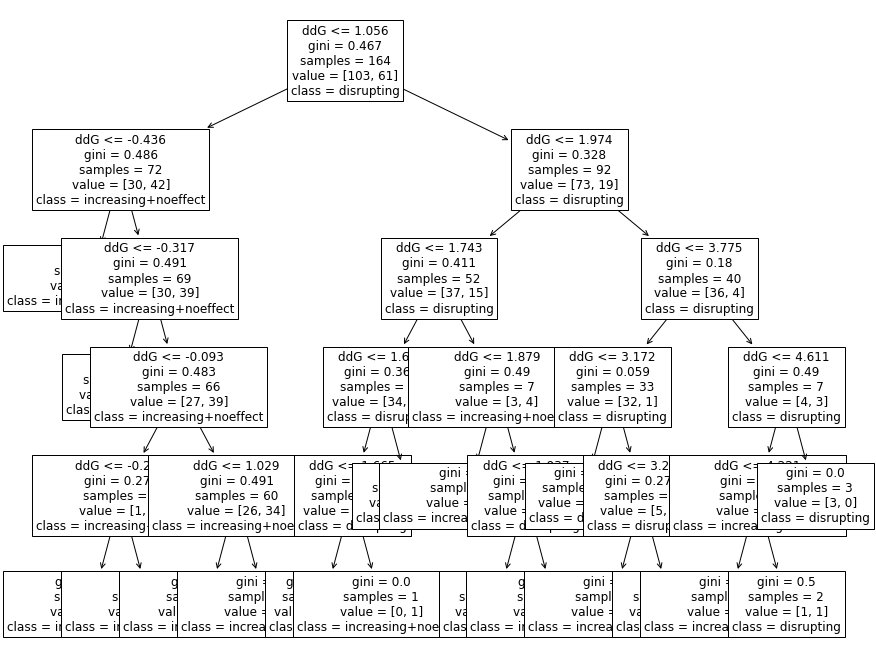

In [23]:
clf_deeper = DecisionTreeClassifier(max_depth=5)
clf_deeper = clf_deeper.fit(X_ddG_sample, y_sample)
print(clf_deeper.tree_.max_depth)
plt.figure(figsize=(14, 12))
tree.plot_tree(clf_deeper, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"], fontsize=12);

In [24]:
from src.helpers.helpers_predator.evaluation import cross_val_score_feature_comparison

In [25]:
cross_val_score_feature_comparison(
    X=X_provean_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineProveanClassifier()
)

0.6258

In [26]:
cross_val_score_feature_comparison(
    X=X_ddG_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineDeltaDeltaGClassifier()
)

0.4426

In [27]:
cross_val_score_feature_comparison(
    X=X_ddG_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineAdaptiveThresholdClassifier()
)

0.6613

In [28]:
def benchmark_single_features(data_materials):
    Xs_ddG = copy.deepcopy(data_materials["Xs_ddG"])
    Xs_provean = copy.deepcopy(data_materials["Xs_provean"])
    ys = copy.deepcopy(data_materials["ys"])

    ddG_balanced_acc_values = []
    ddG_adaptive_balanced_acc_values = []
    provean_balanced_acc_values = []
    provean_adaptive_balanced_acc_values = []

    for X_ddg, X_provean, y in tqdm(zip(Xs_ddG, Xs_provean, ys), total=len(ys)):
        ddG_balanced_acc = cross_val_score_feature_comparison(
            X=X_ddg,
            y=y,
            scoring="balanced_accuracy",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineDeltaDeltaGClassifier()
        )

        ddG_adaptive_balanced_acc = cross_val_score_feature_comparison(
            X=X_ddg,
            y=y,
            scoring="balanced_accuracy",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineAdaptiveThresholdClassifier()
        )

        provean_balanced_acc = cross_val_score_feature_comparison(
            X=X_provean,
            y=y,
            scoring="balanced_accuracy",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineProveanClassifier()
        )

        provean_adaptive_balanced_acc = cross_val_score_feature_comparison(
            X=X_provean,
            y=y,
            scoring="balanced_accuracy",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineProveanClassifier()
        )

        ddG_balanced_acc_values.append(ddG_balanced_acc)
        ddG_adaptive_balanced_acc_values.append(ddG_adaptive_balanced_acc)
        provean_balanced_acc_values.append(provean_balanced_acc)
        provean_adaptive_balanced_acc_values.append(provean_adaptive_balanced_acc)

    results = {
        "$\Delta\Delta$G score only (Fixed threshold)": ddG_balanced_acc_values,
        "$\Delta\Delta$G score only (Adaptive threshold)": ddG_adaptive_balanced_acc_values,
        "Provean score only (Fixed threshold)": provean_balanced_acc_values,
        "Provean score only (Adaptive threshold)": provean_adaptive_balanced_acc_values,
        "METRIC": "BALANCED_ACCURACY",
    }

    return results


In [29]:
obtained_results = benchmark_single_features(predator.data_materials)

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
obtained_results.keys()

dict_keys(['$\\Delta\\Delta$G score only (Fixed threshold)', '$\\Delta\\Delta$G score only (Adaptive threshold)', 'Provean score only (Fixed threshold)', 'Provean score only (Adaptive threshold)', 'METRIC'])

In [31]:
obtained_results["Provean score only (Fixed threshold)"][:3]

[0.6254, 0.608, 0.654]

In [32]:
pd.DataFrame(obtained_results)

,$\Delta\Delta$G score only (Fixed threshold),$\Delta\Delta$G score only (Adaptive threshold),Provean score only (Fixed threshold),Provean score only (Adaptive threshold),METRIC
0,0.4410,0.6676,0.6254,0.6252,BALANCED_ACCURACY
1,0.4651,0.5210,0.6080,0.6078,BALANCED_ACCURACY
2,0.4034,0.6104,0.6540,0.6516,BALANCED_ACCURACY
3,0.3920,0.5409,0.6552,0.6572,BALANCED_ACCURACY
4,0.4281,0.6884,0.6326,0.6351,BALANCED_ACCURACY
5,0.4146,0.6567,0.6741,0.6738,BALANCED_ACCURACY
6,0.4190,0.6738,0.6433,0.6432,BALANCED_ACCURACY
7,0.4468,0.6098,0.6174,0.6175,BALANCED_ACCURACY
8,0.4579,0.5858,0.6190,0.6226,BALANCED_ACCURACY
9,0.4357,0.7090,0.6328,0.6331,BALANCED_ACCURACY


In [33]:
single_features_scores_data = pd.DataFrame(obtained_results)
single_features_scores_data = single_features_scores_data.melt(var_name="FEATURES", value_name="SCORE", id_vars=["METRIC"])
single_features_scores_data = single_features_scores_data[['FEATURES', 'METRIC', 'SCORE']]
single_features_scores_data

,FEATURES,METRIC,SCORE
0,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.4410
1,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.4651
2,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.4034
3,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.3920
4,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.4281
...,...,...,...
195,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6413
196,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6202
197,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6422
198,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6504


In [34]:
import seaborn as sns

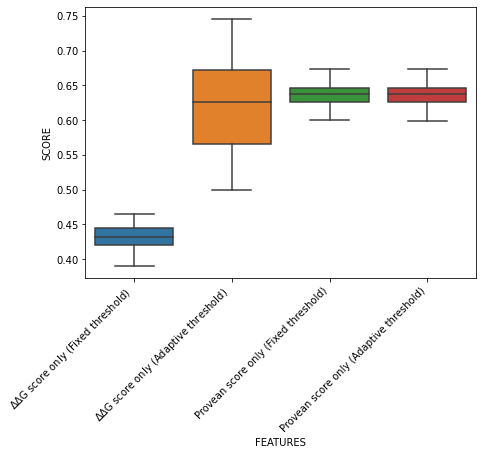

In [35]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=single_features_scores_data, x="FEATURES", y="SCORE")
plt.xticks(ha='right', rotation=45)
plt.show()

In [36]:
def change_shap_top_names(feature_name: str):
    mapping = {
        'Provean': "Provean score only",
        '$\Delta\Delta$G': "$\Delta\Delta$G score only",
        'All Columns': "Predator_all",
        'SHAP Columns (5)': "Predator_SHAP_Top_5",
        'SHAP Columns (10)': "Predator",
        'SHAP Columns (20)': "Predator_SHAP_Top_20",
        'SHAP Columns (30)': "Predator_SHAP_Top_30",
        'SHAP Columns (40)': "Predator_SHAP_Top_40",
    }

    return mapping[feature_name]

In [37]:
scoring_metrics_data_melted = predator.eval_metrics.scoring_metrics_data_melted.copy()
scoring_metrics_data_melted["FEATURES"] = scoring_metrics_data_melted["FEATURES"].apply(lambda x: change_shap_top_names(x))
scoring_metrics_data_melted_balanced_accuracy = scoring_metrics_data_melted[scoring_metrics_data_melted["METRIC"].isin(["BALANCED_ACCURACY"])].copy()
scoring_metrics_data_melted_balanced_accuracy.drop(["X_NAME", "EXPERIMENT_NO"], axis="columns", inplace=True)
scoring_metrics_data_melted_balanced_accuracy

,FEATURES,METRIC,SCORE
8,Provean score only,BALANCED_ACCURACY,0.5210
9,$\Delta\Delta$G score only,BALANCED_ACCURACY,0.4745
10,Predator_all,BALANCED_ACCURACY,0.6732
11,Predator_SHAP_Top_5,BALANCED_ACCURACY,0.6683
12,Predator,BALANCED_ACCURACY,0.7276
...,...,...,...
11,Predator_SHAP_Top_5,BALANCED_ACCURACY,0.6553
12,Predator,BALANCED_ACCURACY,0.6433
13,Predator_SHAP_Top_20,BALANCED_ACCURACY,0.6383
14,Predator_SHAP_Top_30,BALANCED_ACCURACY,0.6297


### Concatenate two scoring dataframes

In [38]:
concated_scoring_data = pd.concat(
    [scoring_metrics_data_melted_balanced_accuracy, single_features_scores_data], axis="rows"
)
concated_scoring_data

,FEATURES,METRIC,SCORE
8,Provean score only,BALANCED_ACCURACY,0.5210
9,$\Delta\Delta$G score only,BALANCED_ACCURACY,0.4745
10,Predator_all,BALANCED_ACCURACY,0.6732
11,Predator_SHAP_Top_5,BALANCED_ACCURACY,0.6683
12,Predator,BALANCED_ACCURACY,0.7276
...,...,...,...
195,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6413
196,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6202
197,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6422
198,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6504


In [39]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

In [40]:
from pandas.api.types import CategoricalDtype

In [41]:
legend_order = [
    'Provean score only',
    'Provean score only (Fixed threshold)',
    'Provean score only (Adaptive threshold)',
    '$\Delta\Delta$G score only',
    '$\Delta\Delta$G score only (Fixed threshold)',
    '$\Delta\Delta$G score only (Adaptive threshold)',
    'Predator_all',
    'Predator_SHAP_Top_5',
    'Predator',
    'Predator_SHAP_Top_20',
    'Predator_SHAP_Top_30',
    'Predator_SHAP_Top_40',
]

cat_size_order = CategoricalDtype(
    legend_order, ordered=True
)
cat_size_order

CategoricalDtype(categories=['Provean score only', 'Provean score only (Fixed threshold)',
                  'Provean score only (Adaptive threshold)',
                  '$\Delta\Delta$G score only',
                  '$\Delta\Delta$G score only (Fixed threshold)',
                  '$\Delta\Delta$G score only (Adaptive threshold)',
                  'Predator_all', 'Predator_SHAP_Top_5', 'Predator',
                  'Predator_SHAP_Top_20', 'Predator_SHAP_Top_30',
                  'Predator_SHAP_Top_40'],
, ordered=True)

In [42]:
concated_scoring_data["FEATURES"] = concated_scoring_data["FEATURES"].astype(cat_size_order)
concated_scoring_data

,FEATURES,METRIC,SCORE
8,Provean score only,BALANCED_ACCURACY,0.5210
9,$\Delta\Delta$G score only,BALANCED_ACCURACY,0.4745
10,Predator_all,BALANCED_ACCURACY,0.6732
11,Predator_SHAP_Top_5,BALANCED_ACCURACY,0.6683
12,Predator,BALANCED_ACCURACY,0.7276
...,...,...,...
195,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6413
196,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6202
197,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6422
198,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6504


In [43]:
concated_scoring_data = concated_scoring_data.sort_values(["FEATURES"])

In [143]:
from datetime import datetime

In [136]:
import os.path as op

In [148]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator


def plot_performance_comparison_results(scoring_metrics_data_melted, metrics, filename):
    # sns.set_theme(style="ticks", palette="pastel", font_scale=1.5)  # TODO: POSTER,uncommendLATER
    sns.set_theme(style="ticks", font_scale=2)  ## palette="pastel"
    # sns.set_theme(style="white", font_scale=2)  ## palette="pastel"

    colors_12 = [
        # provean
        "#F2F2AE",
        "#F2C900", # F2DE5C
        "#A6915F", # F2C900
        # ddG
        "#B7E1EE", # B9BFC4, 7FB3C2
        "#609BB1", # 609BB1, 24849D
        "#105B7A",  # FF616D
        # predators
        "#F0F1F1", # Predator All  # C6AAB6
        "#C6AAB6", # Predator 5  # AC7F93
        "#E81123", # Predator 10  # FF616D, F2ECDB, E81123
        "#AC7F93", # Predator 20
        "#965B77", # Predator 30
        "#823960", # Predator 40
    ]
    sns.set_palette(sns.color_palette(colors_12))


    # TODO: [later] plot size adjusting itself depending on input ↓
    # plt.figure(figsize=(3 * len(metrics), 7))
    plt.figure(figsize=(8, 7))
    # title_string_1 = fr"Performance\ Comparison\ of\ Selected\ Features\ vs.\ All\ Features"
    # title_string_2 = fr"CV = 10, CV\_repeat = {self.n_repeats}, Experiment\_repeat = {self.n_experiment}"
    # title_string_1 = fr"Performance\ Comparison\ of\ Selected\ Features"
    # title_string_2 = ""
    title_string_1 = fr"Balanced\ Accuracy\ of\ Feature\ Sets"
    title_string_2 = ""
    # plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontsize=24, fontweight='bold')
    # plt.ylabel('Metrics', fontsize=24, fontweight='bold')
    #     plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontsize=24, fontweight='bold')
    #     plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontweight='bold')
    plt.title(f"$\mathbf{{{title_string_1}}}$", fontweight='bold')

    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.8, lw=0.5)
    # noinspection SpellCheckingInspection

    if metrics is not None:
        scoring_metrics_data_melted_less_metrics = scoring_metrics_data_melted[
            scoring_metrics_data_melted['METRIC'].isin(metrics)
        ]
        scoring_metrics_data_plot = scoring_metrics_data_melted_less_metrics

    else:
        scoring_metrics_data_plot = scoring_metrics_data_melted

    # ax = sns.boxplot(x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data_melted_less_metrics,
    #                  palette='Pastel1')  # bone, vlag, cividis, #03012d, light:#444452

    ax = sns.boxplot(
        x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data_plot, saturation=1
    )
    # palette='deep')  # bone, vlag, cividis, #03012d, light:#444452

    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    #     ax.xaxis.grid(True, which='minor', color='#ababab', lw=1)
    # legend = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), edgecolor="black") ############
    # legend.get_frame().set_alpha(None)
    ###################
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), framealpha=0)
    # plt.tight_layout()  # poster purpose
    # plt.savefig('foo2.png')  # poster purpose


    #     plt.ylabel('Metrics', fontsize=24, fontweight='bold')
    #     plt.ylabel('Balanced Accuracy', fontsize=16, fontweight='bold')
    plt.ylabel('Balanced Accuracy')
    #     plt.xlabel('Balanced Accuracy', fontsize=24, fontweight='bold')

    plt.xticks([])
    plt.xlabel('', fontsize=24, fontweight='bold')

    file_date = datetime.today().strftime('%Y-%m-%d')

    if filename is None:
        filename = f"figures/performance_comparison_selected_features_{file_date}.pdf"
    else:
        filename = f"figures/{filename}_{file_date}.pdf"

    if op.isfile(filename):
            raise FileExistsError
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Plot {filename} is exported.")

    plt.show()
    # sns.despine(offset=10, trim=True)


Plot figures/performance_comparison_selected_features_balanced_acc_2021-12-26.pdf is exported.


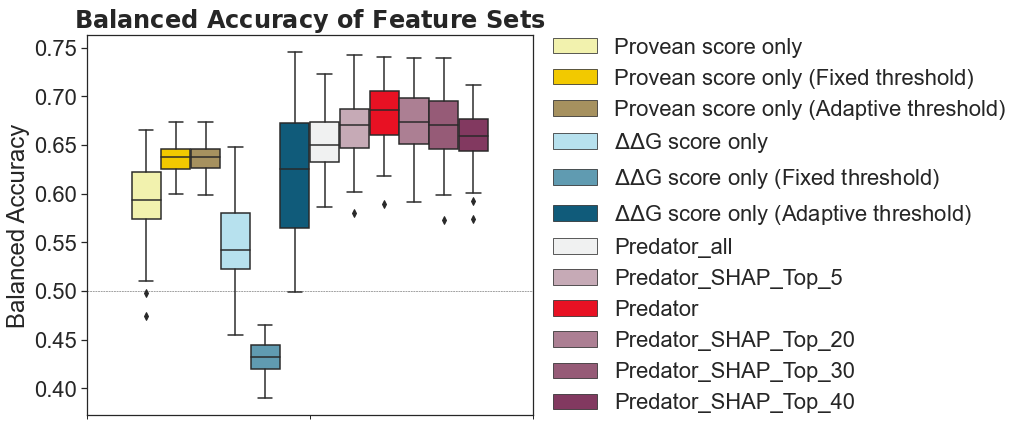

In [149]:
metrics = ["BALANCED_ACCURACY"]
plot_performance_comparison_results(
    concated_scoring_data, metrics, "performance_comparison_selected_features_balanced_acc"
)

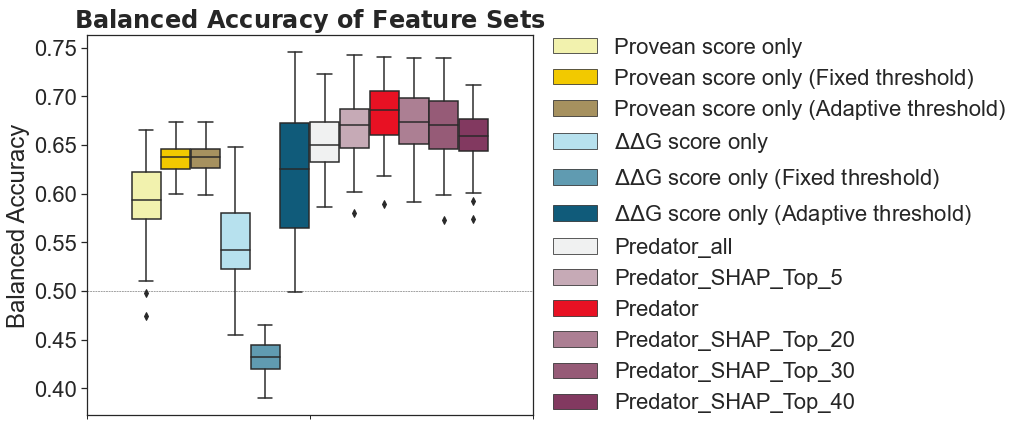

In [131]:
metrics = ["BALANCED_ACCURACY"]
plot_performance_comparison_results(
    concated_scoring_data, metrics, "performance_comparison_selected_features_balanced_acc"
)